In [2]:
import jax
import jax.numpy as jnp
from jax import jit, grad, vmap, value_and_grad
from jax import random
from jax.scipy.special import logsumexp
from jax.experimental import optimizers

import torch
from torchvision import datasets, transforms

import time
import matplotlib.pyplot as plt

We will need a function that initializes the weights for our MLP. We need to split the key iteratively to generate individual weights of our network.

In [3]:
# A helper function to randomly initialize weights and biases
def initialize_mlp(sizes, key):
  """Initialize the weights of all layers of a linear layer network"""
  keys = random.split(key, len(sizes))
  # Initialize a single layer with Gaussian weights - helper function
  def initialize_layer(m, n,key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
  return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
# Return a list of tuples of layer weights 
key = random.PRNGKey(1)
layer_sizes = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 10
batch_size = 128
n_targets = 10
params = initialize_mlp(layer_sizes, key)

In [4]:
# Utility functions built from scratch
def relu_layer(x):
  return jnp.maximum(0, x)

def forward_pass(params, in_array):
  """Forward pass for a single image"""
  activations = in_array
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu_layer(outputs)

  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)



In [5]:
# Dry run to check if our prediction function works on a single image
image = random.normal(key, (784,))
preds = forward_pass(params, image)
print(preds.shape)

(10,)


In [6]:
# Batched version of `forward_pass` function
batch_forward_pass = vmap(jit(forward_pass), in_axes=(None, 0), out_axes=0)

Next we need gradient descent. For gradient descent, we need to define the loss function which we want to optimize. This is going to be multi-class cross-entropy between one-hot encoded class labels and the softmax output of the network.

$$∑_{c=1}^{10}y_ilogp_c^\theta({x_i})$$

In [7]:
def one_hot_encoding(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k """
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

def loss(params, in_arrays, targets):
    """ Compute the multi-class cross-entropy loss """
    preds = batch_forward_pass(params, in_arrays)
    return -jnp.sum(preds * targets)
  
def accuracy(params, data_loader):
    """ Compute the accuracy for a provided dataloader """
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = jnp.array(data).reshape(data.size(0), 28*28)
        targets = one_hot_encoding(jnp.array(target), n_targets)
    
        target_class = jnp.argmax(targets, axis=1)
        predicted_class = jnp.argmax(batch_forward_pass(params, images), axis=1)
        acc_total += jnp.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

Now we need to define the update function which will be a single step for our gradient descent algorithm. I used the predefined optimizer Adam for this purpose. The wrapper `@jit` is used to make the computation faster.

In [8]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value
    # return loss, jax.tree_multimap(lambda p, g: p - lr * g, params, grads)

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

# Data Loading

We will use Pytorch's `torchvision` library to download the data and use this with 80:20 train:test split.

In [9]:
transform = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Normalize((0.1313,), (0.3081,))])

dataset = datasets.MNIST(root = './data', transform = transform, download=True)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [10]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

It's time to define the learning loop for our 2-layer MLP! 

Epoch 1 | T: 22.54 | Train A: 0.970 | Test A: 0.965
Epoch 2 | T: 21.50 | Train A: 0.982 | Test A: 0.972
Epoch 3 | T: 21.63 | Train A: 0.985 | Test A: 0.975
Epoch 4 | T: 21.51 | Train A: 0.993 | Test A: 0.977
Epoch 5 | T: 21.67 | Train A: 0.995 | Test A: 0.978
Epoch 6 | T: 21.86 | Train A: 0.994 | Test A: 0.977
Epoch 7 | T: 22.05 | Train A: 0.997 | Test A: 0.980
Epoch 8 | T: 22.05 | Train A: 0.998 | Test A: 0.979
Epoch 9 | T: 21.76 | Train A: 0.999 | Test A: 0.979
Epoch 10 | T: 21.70 | Train A: 0.997 | Test A: 0.980


Text(0, 0.5, '# Epochs')

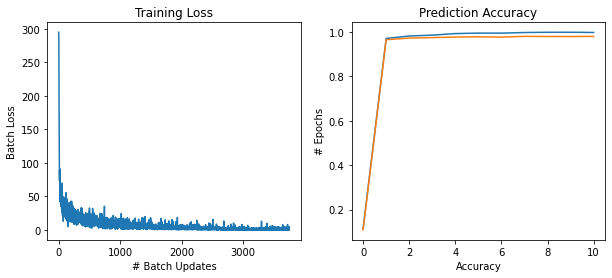

In [11]:
def run_mnist_training_loop(num_epochs, opt_state):
  """A Learning loop over epochs """
  # placeholder for loggin
  log_acc_train, log_acc_test, train_loss = [], [], []

  # Get initial set of parameters
  params = get_params(opt_state)

  # Get initial accuracy
  train_acc = accuracy(params, train_loader)
  test_acc = accuracy(params, test_loader)
  log_acc_train.append(train_acc)
  log_acc_test.append(test_acc)
  # Loop over the training epochs
  for epoch in range(num_epochs):
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
      x = jnp.array(data).reshape(data.size(0), 28*28)
      y = one_hot_encoding(jnp.array(target), n_targets)
      loop_params = update(params, x, y, opt_state)
      params, opt_state, loss = update(params, x, y, opt_state)
      # loss = update(params, x, y, opt_state)
      train_loss.append(loss)
    epoch_time = time.time() - start_time

    train_acc = accuracy(params, train_loader)
    test_acc = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)
    print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                              train_acc, test_acc))
  return log_acc_train, log_acc_test, train_loss

train_log, test_log, train_loss = run_mnist_training_loop(num_epochs, opt_state)

# Plotting the results
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# axs[0].subplot(1, 2, 1)
axs[0].plot(train_loss)
axs[0].set_title("Training Loss")
axs[0].set_xlabel("# Batch Updates")
axs[0].set_ylabel("Batch Loss")
# plt.subplot(1, 2, 2)
axs[1].plot(train_log, label="Training")
axs[1].plot(test_log, label="Test")
axs[1].set_title("Prediction Accuracy")
axs[1].set_xlabel("Accuracy")
axs[1].set_ylabel("# Epochs")

### References
1. [Official github repository for JAX](https://github.com/google/jax)
2. [Trainig a Simple Neural Network with PyTorch Data Loading](https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html)
3. [Getting started with JAX](https://roberttlange.github.io/posts/2020/03/blog-post-10/)
